In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Setup paths 
# Use dictionaries due to inconsistent length of arrays and better overview
# Setup 'pols', as it will be iterated over a lot due to the dictionaries
pols = ("HH", "VV")
data = {}
data[pols[0]] = "data_VV.csv"
data[pols[1]] = "data_HH.csv"

In [3]:
# Import raw data, reformat dates
dates, mean, std = {}, {}, {}
for pol in pols:
    mean[pol], std[pol] = np.loadtxt(data[pol], delimiter=",", skiprows=1, usecols=(3, 4), unpack=True)
    dates_raw = np.loadtxt(data[pol], delimiter=",", skiprows=1, usecols=0, dtype=np.str_)
    dates[pol] = np.array([dt.datetime.strptime(dates_raw[i][:10], "%Y-%m-%d").date() for i in range(len(dates_raw))])

In [4]:
# Create masks for filtering out each single year included in the data
masks = {}
for pol in pols:
    yrs = np.array([i.year for i in dates[pol]])
    masks[pol] = {str(i): yrs == i for i in np.unique(yrs)}

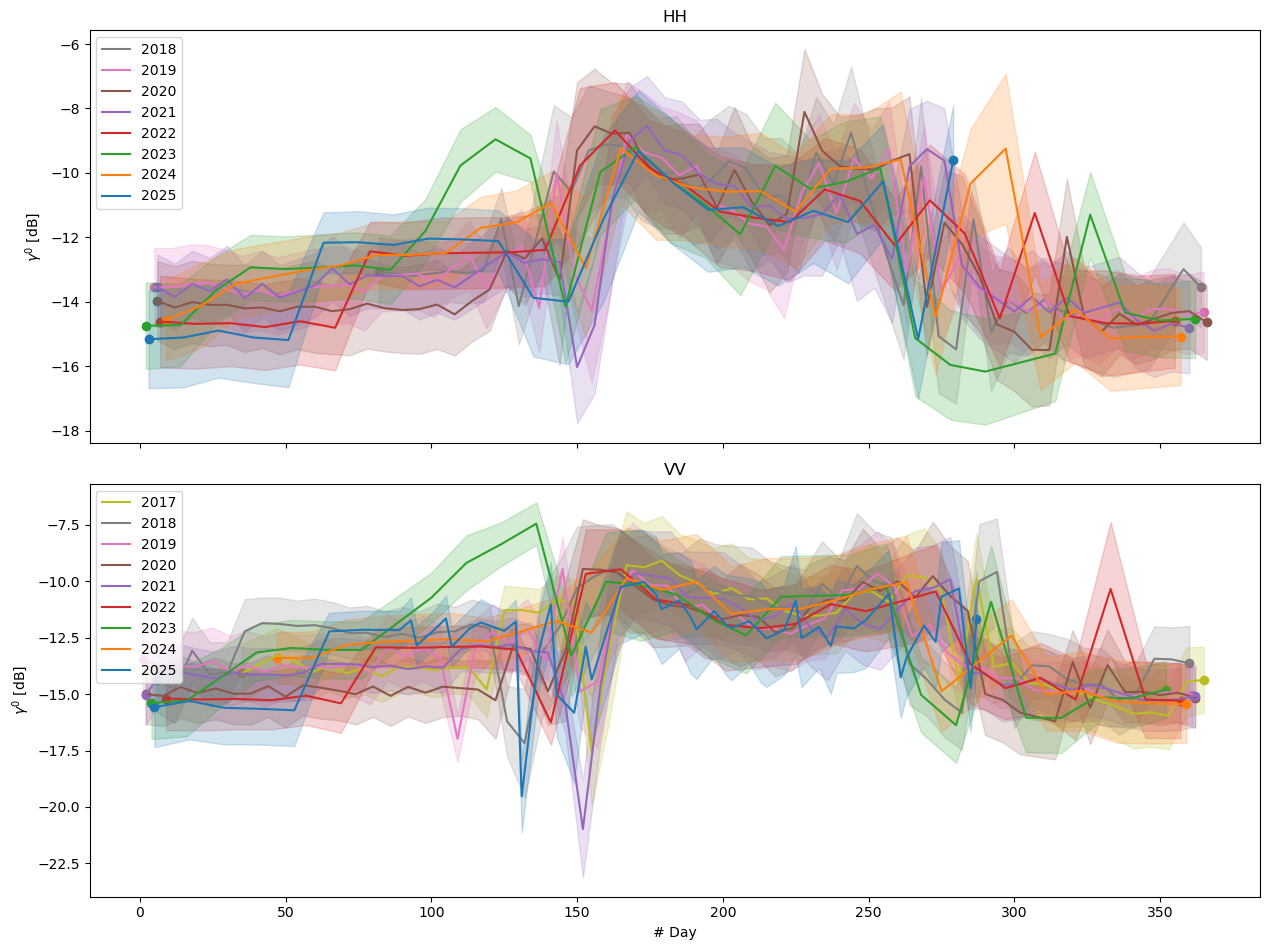

In [8]:
# Create figure
cmap = plt.get_cmap("tab10")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12.8, 9.6), layout="tight")

# Filter out relevant data and plot backscatter for each available day in the year while saving in dictionaries
x, y, yerr = {}, {}, {}
for k, pol in enumerate(pols):
    mask = masks[pol]

    # This was the most sensible way for me to apply the masks and write the data in a new dict
    x[pol] = {j: np.array([i.timetuple().tm_yday for i in dates[pol][mask[j]]]) for j in mask}
    y[pol] = {i: mean[pol][mask[i]] for i in mask}
    yerr[pol] = {i: std[pol][mask[i]] for i in mask}
    
    for yr_id, yr_str in enumerate(mask):
        # Keep count of year for color management
        c = len(mask) - yr_id - 1
        
        # This would look incomprehensible without reassigning the data to plot to local variables
        x_yr, y_yr, yerr_yr = x[pol][yr_str], y[pol][yr_str], yerr[pol][yr_str]

        # Thin line
        axs[k].plot(x_yr, y_yr, label=yr_str, color=cmap(c))

        # Error bar
        axs[k].fill_between(x_yr, y_yr + yerr_yr, y_yr - yerr_yr, color=cmap(c), alpha=0.2)

        # Start- and Endpoint
        axs[k].scatter((x_yr[0], x_yr[-1]), (y_yr[0], y_yr[-1]), color=cmap(c))
        
    axs[k].set_title(pol)
    plt.xlabel("# Day")
    axs[k].set_ylabel("$\\gamma^0$ [dB]")
    axs[k].legend(loc="upper left")
#plt.savefig("reindalen_gamma0.png")
plt.savefig("reindalen_gamma0.pdf")
plt.show()

In [6]:
start, stop = 160, 250
x_filtered, y_filtered = {}, {}
for pol in pols:
    filter = {i: np.array(x[pol][i] > start) & np.array(x[pol][i] < stop) for i in x[pol]}
    x_filtered[pol] = {i: x[pol][i][filter[i]] for i in filter}
    y_filtered[pol] = {i: y[pol][i][filter[i]] for i in filter}

NameError: name 'make_smoothing_spline' is not defined

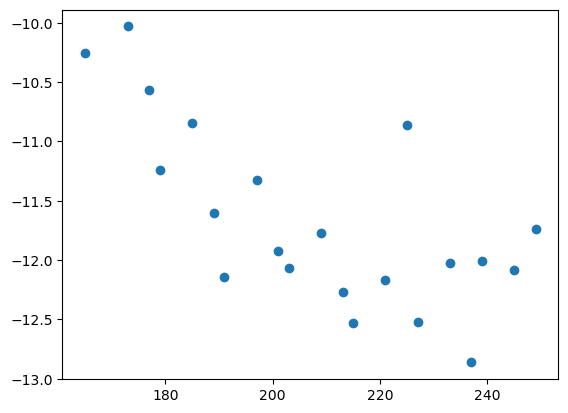

In [7]:
t_x, t_y = x_filtered["VV"]["2025"], y_filtered["VV"]["2025"]
x_new = np.linspace(t_x[0], t_x[-1], 101)
plt.scatter(t_x, t_y)
plt.plot(x_new, make_smoothing_spline(t_x, t_y, lam=300)(x_new))

plt.show()